In [52]:
import pandas as pd, numpy as np, mglearn, numpy.linalg as nl, inspect, seaborn as sns, plotly, plotly.express as px,umap, pickle, plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tqdm import tqdm
from matplotlib.pyplot import *
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import NearestNeighbors
pd.options.display.float_format = '{:,.4f}'.format

In [53]:
train_x = pd.read_csv('Data/X_train.csv',header=None)
train_y = pd.read_csv('Data/y_train.csv',header=None).values.reshape(-1)
test_x = pd.read_csv('Data/X_test.csv',header=None)
test_y = pd.read_csv('Data/y_test.csv',header=None).values.reshape(-1)

In [54]:
out_dir = Path('output')
out_dir.mkdir(exist_ok=True)
res_dir = Path('results')
res_dir.mkdir(exist_ok=True)
train_model = False
save = True

In [55]:
def make_df(model_list,opt_list):
    #Edited from my final last semester for simpler models
    #Since not all models require the same option lists, we can run this on each pairing and merge.
    result = []
    for model_gen in model_list:
        for option in opt_list:
            model_id, model = model_gen(option)
            result.append([f'{model_id}_{option:.2f}', model_id, model,option])
    return pd.DataFrame(columns = ['ID','Model_ID','Model', 'Attribute'],data=result)
def rbf(distances):
    return np.exp(-distances**2/(2))
# def knn(neighbor):
#     return inspect.stack()[0][3], KNeighborsClassifier(n_neighbors=int(neighbor)) #I know this can cause issues, but it's worth it for this.

In [56]:
def load_model(model,loc=out_dir):
    filname = list(Path(loc).rglob('*'+model+'*'))
    if len(filname) == 0:
        raise ValueError("Can't find the file!")
    if len(filname) >1:
        raise ValueError("Located too many items matching that search. Please try again. We found: {}".format(filname))
    filname = filname[0]
    with open(filname,'rb') as fil:
        temp = pickle.load(fil)
    return temp

def seaborn_friendly(res):
    res['mean_score'] = res[['mean_train_score','mean_test_score']].values.tolist()
    res['type'] = [['train','test']]*res.shape[0]
    res['std_score'] = res[['std_train_score','std_test_score']].values.tolist()
    res = res.explode(['mean_score','type','std_score'],ignore_index=True)
    return res

def plot_cv_param_res(res,xs, param, save=False, out_dir = '.',key='model', y='mean_score'):
    test = seaborn_friendly(res)
    if isinstance(xs,str):
        xs = [xs] 
    for x in xs:
        ax = sns.lineplot(x=x, y=y,hue=param,style='type',data=test)
        ax.set(title="{} {} by {}".format(key.upper(),y,param))
        if save:
            ax.get_figure().savefig(Path(out_dir,f"{param}_{y}_{x}.png"))
        show()

In [57]:
if train_model:
    distance_options = ['uniform','distance',rbf]
    neighbor_options = np.arange(100) + 1
    knn_grid = {'n_neighbors':neighbor_options, 'weights':distance_options}
    knn = KNeighborsClassifier()
    knn_cv = GridSearchCV(knn, knn_grid,n_jobs=-1,verbose=10, cv=4,return_train_score=True)
    knn_cv.fit(train_x,train_y)
    if save:
        with open(Path(out_dir,'knn_cv.pkl'),'wb') as fil:
            pickle.dump(knn_cv, fil)
    del(knn_cv)

    nb = MultinomialNB()
    alphas = np.linspace(0.01, 5, 100) # Set to be more later tonight (was 51)
    nb_grid = {'alpha':alphas, 'fit_prior':[True, False]}
    nb_cv = GridSearchCV(nb, nb_grid, n_jobs=-1,verbose=10, cv=4,return_train_score=True)
    nb_cv.fit(train_x,train_y)
    if save:
        with open(Path(out_dir,'nb_cv.pkl'),'wb') as fil:
            pickle.dump(nb_cv, fil)
    del(nb_cv)

    rf = RandomForestClassifier()
    estimators = np.arange(100, 1000, 50) # Originally 100, 1000, 100
    max_depth = list(range(10,100, 10)) 
    max_depth.append(None)
    max_features = ['sqrt','log2']
    rf_grid = {'n_estimators':estimators, 'max_depth':max_depth, 'max_features':max_features}
    rf_cv = GridSearchCV(rf, rf_grid, n_jobs=-1,verbose=10, cv=4,return_train_score=True)
    rf_cv.fit(train_x,train_y)
    if save:
        with open(Path(out_dir,'rf_cv.pkl'),'wb') as fil:
            pickle.dump(rf_cv, fil)
    del(rf_cv)

    gb = GradientBoostingClassifier()
    losses = ['log_loss','exponential']
    learning_rates = np.linspace(.01, 2, 25)
    n_estimators = np.arange(100,700, 100)
    gb_grid = {'loss':losses,'learning_rate' : learning_rates, "n_estimators":n_estimators}
    gb_cv = GridSearchCV(gb, gb_grid,n_jobs=-1,verbose=10, cv=4,return_train_score=True)
    gb_cv.fit(train_x,train_y)
    if save:
        with open(Path(out_dir,'gb_cv.pkl'),'wb') as fil:
            pickle.dump(gb_cv, fil)
    del(gb_cv)

In [58]:
def analyze(key, x, test_x, test_y, save=False, out_dir='.', loc=out_dir):
    model_res = load_model(key,loc=loc)
    df =  pd.DataFrame.from_dict(model_res.cv_results_)
    if 'knn' in key:
        #Bootlegged solution to an annoying naming problem
        df.loc[~df['param_weights'].isin(['uniform','distance']),'param_weights'] = 'rbf'
    if 'rf' in key:
        #Switch out the value with no limit of depth to be in line with the others, but slightly separated to notice it better.
        mask = df['param_max_depth'].isna()
        df.loc[mask,'param_max_depth'] = df.loc[~mask, 'param_max_depth'].max()+2*df.loc[~mask, 'param_max_depth'].diff().max()
    ys = df.filter(regex='param').columns
    model_res_dir = Path(out_dir,key)
    if save:
        model_res_dir.mkdir(exist_ok=True)
    if isinstance(x,str):
        droppables = [x,'params']
    else:
        droppables = x + ['params']
        contour_continuous(df,x[0],x[1],'{} Continuous Test Accuracy'.format(key.upper()), save=save, out_dir=model_res_dir)
    ys = ys.drop(droppables)
    for param in ys:
        plot_cv_param_res(df, x, param, save=save, out_dir=model_res_dir, key = key)
        plot_cv_param_res(df, x, param, save=save, out_dir=model_res_dir, key = key,y='mean_fit_time')
    best_res = handle_best(key, test_x, test_y, save=save, out_dir=model_res_dir)
    return df, best_res
    
def contour_continuous(df, x, y, title='placeholder',save = False, out_dir='.'):
    fig = go.Figure(data= go.Contour(z=df['mean_test_score'],x=df[x],y = df[y]))
    fig.update_layout(title=title, xaxis_title=x, yaxis_title=y)
    if save:
        plotly.offline.plot(fig, filename=str(Path(out_dir,'contour.html')),auto_open=False)
    fig.show()

def handle_best(key, test_x, test_y, save=False, out_dir = out_dir):
    res = load_model(key)
    best_model = res.best_estimator_    
    df =  pd.DataFrame.from_dict(res.cv_results_)
    best_res = df.iloc[res.best_index_]
    best_res['best_final_test'] = best_model.score(test_x,test_y)
    best_res['best_cv_test'] = res.cv_results_['mean_test_score'][res.best_index_]
    best_res['best_cv_train'] = res.cv_results_['mean_train_score'][res.best_index_]
    if save:
        print(out_dir)
        best_res.to_csv(Path(out_dir,'{}_best_results.csv'.format(key)))
        best_res.to_latex(Path(out_dir,'{}_best_results.tex'.format(key)))
    return best_res

def wrap_up(res_dir):
    df = pd.concat([pd.read_csv(i,index_col=0,names=[i.name.split('_')[0]],header=None) for i in res_dir.rglob("*best_results.csv")],axis=1).dropna()
    df.rename(index={df.index[0]:'Index'},inplace=True)
    df.to_csv(Path(res_dir,'all_best.csv'),float_format='%.4f')
    df.to_latex(Path(res_dir,'all_best.tex'),float_format='%.4f')


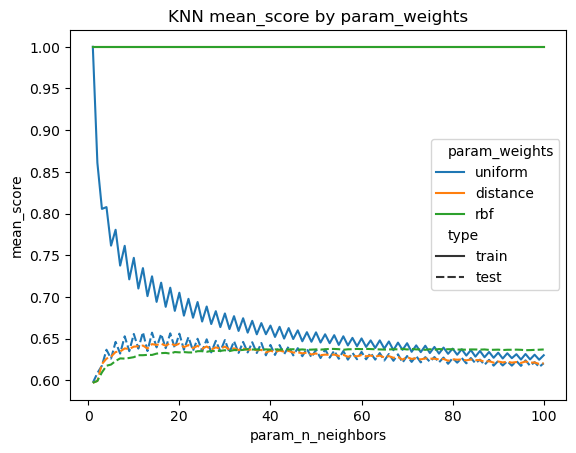

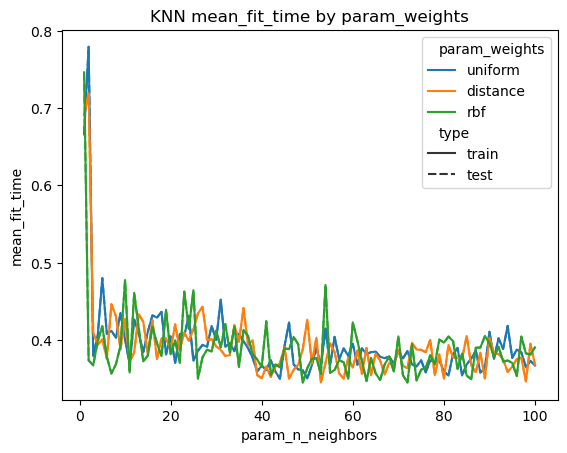

results/knn


/tmp/ipykernel_15481/3087642372.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/3087642372.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/3087642372.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/3087642372.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

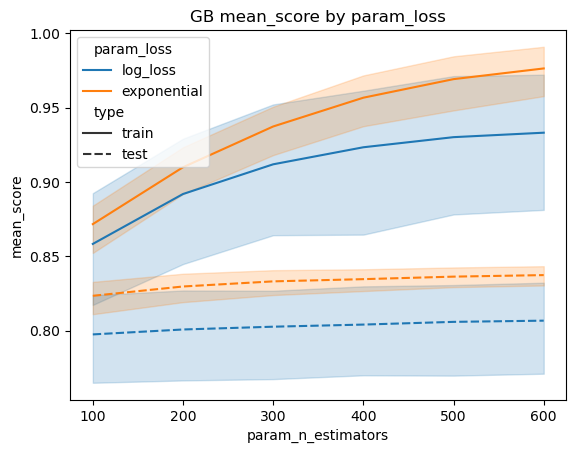

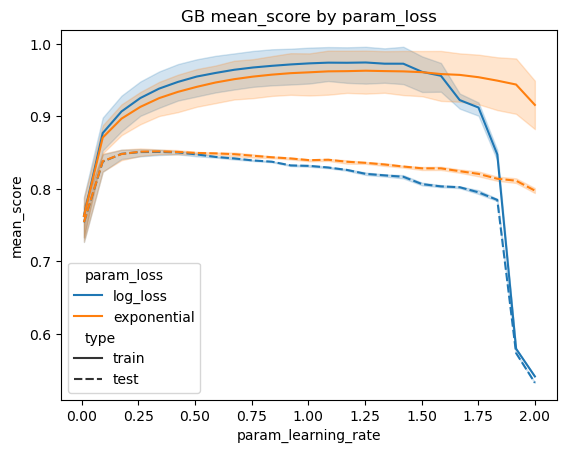

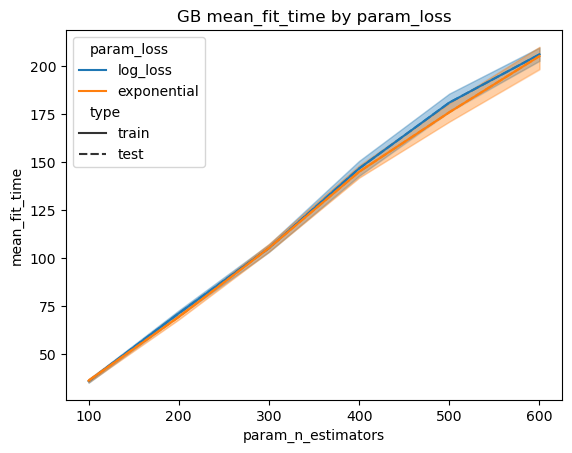

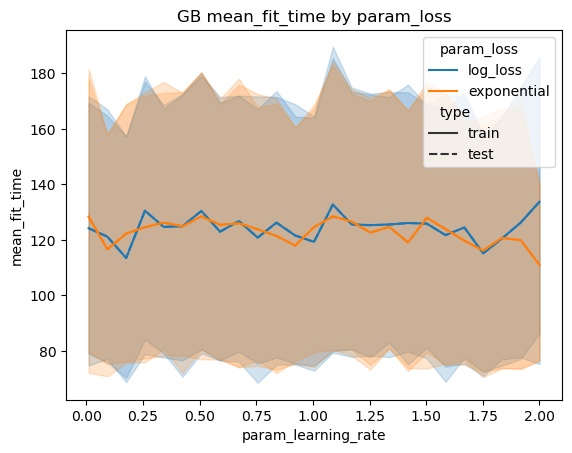

results/gb


/tmp/ipykernel_15481/3087642372.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/3087642372.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/3087642372.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/3087642372.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

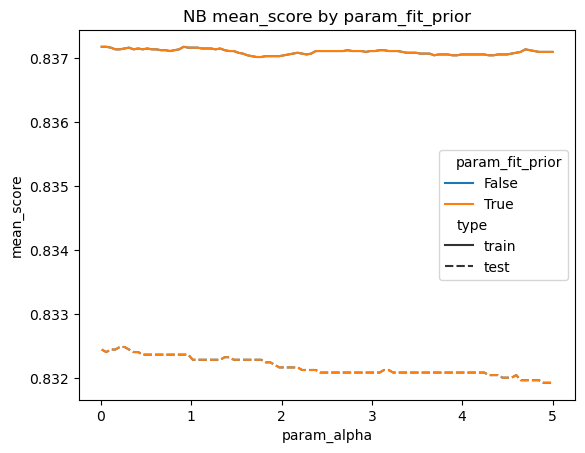

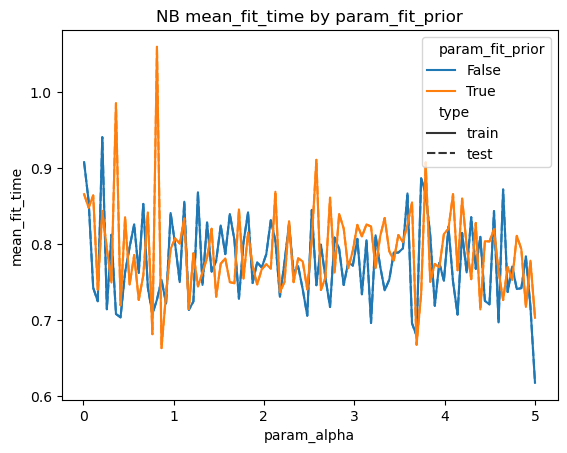

/tmp/ipykernel_15481/3087642372.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/3087642372.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/3087642372.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/3087642372.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

results/nb


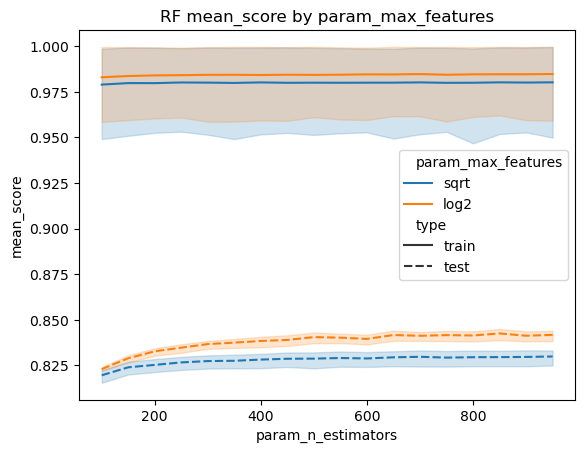

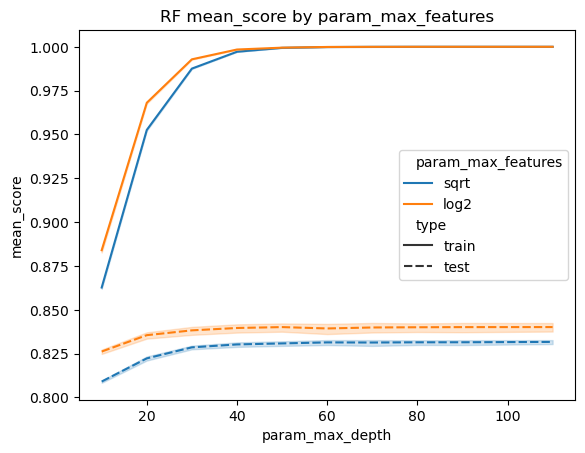

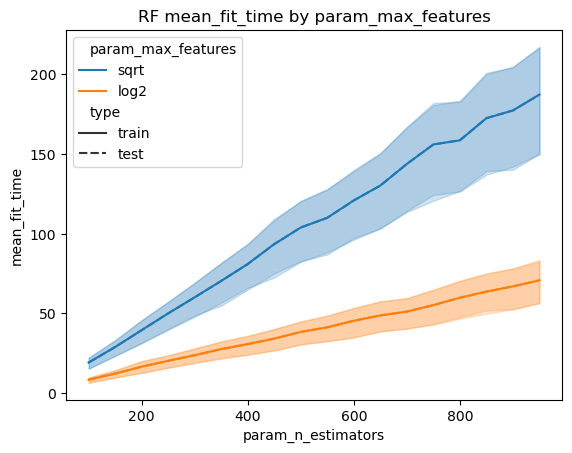

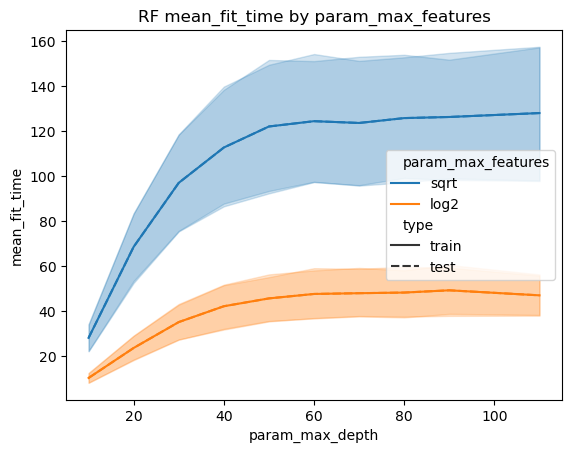

results/rf


/tmp/ipykernel_15481/3087642372.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/3087642372.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/3087642372.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/3087642372.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

In [59]:
keys = ['knn','gb','nb','rf']
xs = ['param_n_neighbors',['param_n_estimators','param_learning_rate'],'param_alpha',['param_n_estimators','param_max_depth']]
df_dict = {}
for key, x in zip(keys,xs):
    temp = analyze(key,x, test_x, test_y, save=save, out_dir=res_dir)
    if key not in df_dict.keys():
        df_dict[key] = temp
#This is to combine the resulting best data into one table for everything
if save:
    wrap_up(res_dir)

    


In [60]:
def knn_analyze(test_x,test_y,save=True,out_dir='.'):
    best = load_model('knn').best_estimator_
    y_pred = best.predict(test_x)
    misclassified_indices = np.where((y_pred!=test_y))[0]
    k = best.get_params()['n_neighbors']
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(train_x)
    distances, indices = nn.kneighbors(test_x.iloc[misclassified_indices])
    columns = ["Misclassified Test idx", "True Class", "Pred Class"]
    for i in range(k):
        columns+= ["Neigbor#{}_idx".format(i+1), "Neigbor#{}_True Class".format(i+1), "Neigbor#{}_Distance".format(i+1)]

    df = pd.DataFrame(columns = columns)

    df["Misclassified Test idx"] = misclassified_indices
    df["True Class"] =  test_y[misclassified_indices]
    df["Pred Class"] = y_pred[misclassified_indices]
    for i in range(k):
        df["Neigbor#{}_idx".format(i+1)] = indices[:,i]
        df["Neigbor#{}_True Class".format(i+1)] = train_y[indices[:,i]]
        df["Neigbor#{}_Distance".format(i+1)] = np.around(distances[:,i], decimals=2)
    df["Neighbor_average_Distance"] = distances.mean(axis=1)
    fig = df.sort_values('Neighbor_average_Distance').reset_index()['Neighbor_average_Distance'].plot(title="KNN_Average_Distance",xlabel="Sample",ylabel="Distance")
    if save:
        fig.figure.savefig(Path(out_dir,"KNN_Average_Distance.png"))
def tree_analyze(save=False, out_dir = '.'):
    best_gb = load_model('gb').best_estimator_
    best_rf = load_model('rf').best_estimator_
    gb_importance = pd.Series(best_gb.feature_importances_, index=train_x.columns, name='gb')
    rf_importance = pd.Series(best_rf.feature_importances_, index=train_x.columns,name='rf')
    importance = pd.concat([rf_importance, gb_importance],axis=1)
    importance/=importance.max(axis=0)
    plot_importance(importance, 'tree', 'rf','gb', save=save,out_dir=out_dir)

def plot_importance(importance, name, x,y, save=False,out_dir='.'):
    fig = px.scatter(importance,x,y,hover_name= 'Feature ' + importance.index.astype(str),title='Comparing Normalized Feature Importance')
    if save:
        fig.write_html(Path(out_dir,f'{name}_comparison.html'))
        fig.write_image(Path(out_dir,f'{name}_comparison.png'))
    fig.show()

def nb_analyze(save=False,out_dir='.'):
    best_nb = load_model('nb').best_estimator_
    importance = pd.DataFrame(data = best_nb.feature_log_prob_.T,columns = [0,1])
    plot_importance(importance, 'nb', 0, 1, save=save,out_dir=out_dir)


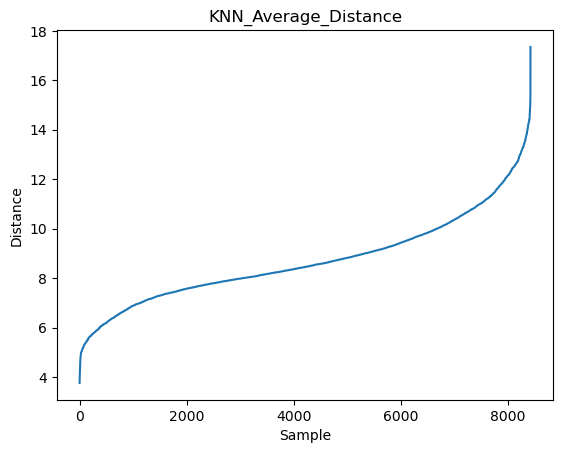

In [61]:

knn_analyze(test_x, test_y, save=save, out_dir=Path(res_dir,'knn'))
tree_analyze(save=save,out_dir=res_dir)
nb_analyze(save=save, out_dir=res_dir)

In [62]:
#This is to combine the resulting best data into one table for everything
df = pd.concat([pd.read_csv(i,index_col=0,names=[i.name.split('_')[0]],header=None) for i in res_dir.rglob("*best_results.csv")],axis=1).dropna()


In [63]:
res = load_model('gb')
best_model = res.best_estimator_    
df =  pd.DataFrame.from_dict(res.cv_results_)
best_res = df.iloc[res.best_index_]
best_res['best_final_test'] = best_model.score(test_x,test_y)


/tmp/ipykernel_15481/2635140768.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_15481/2635140768.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

